# packages and functions (run before hand)

In [2]:
%reset

In [7]:
from pathlib import Path
import networkx as nx
import pandas as pd
import csv
import json
import re
import nltk
import numpy as np
import matplotlib.pyplot as plt
import ast
from collections import defaultdict, Counter
from nltk.tokenize import word_tokenize
import html

def load_word_list(p: Path):
    #path_to_word_list = r"C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Hedonometer.csv"
    path_to_word_list = r"/Users/iben/Desktop/Social_graphs/SocialGraphs/Hedonometer.csv"
    p = Path(path_to_word_list)

    df = pd.read_csv(p, encoding='utf-8', engine='python')
    word_col_candidates = [c for c in df.columns if 'word' in c.lower()]
    score_col_candidates = [c for c in df.columns if 'happiness' in c.lower() or 'score' in c.lower()]

    if word_col_candidates:
        word_col = word_col_candidates[0]
    else:
        word_col = df.columns[0]  # fallback

    if score_col_candidates:
        score_col = score_col_candidates[0]
    else:
        # fallback: first numeric column
        num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
        score_col = num_cols[0] if num_cols else df.columns[1]

    w_l = dict(zip(df[word_col].astype(str).str.lower(), df[score_col].astype(float)))

    if score_col is None and df.shape[1] >= 2:
        score_col = df.columns[1]
    w_l = dict(zip(df[word_col].astype(str).str.lower(), df[score_col].astype(float)))

    return w_l

def calculate_sentiment(tokens, labmt_data=None):
    """
    Calculate average sentiment score for a list of tokens using LabMT word list

    """
    # Get scores for tokens that exist in labmt
    scores = [labmt_data[token] for token in tokens if token in labmt_data]

    # Return average if we found any scores, otherwise return neutral score (5.0)
    if scores:
        return sum(scores) / len(scores)
    return 5.0

def tokenize(text):
    tokens = word_tokenize(text.lower())
    return [t for t in tokens if t.isalpha()]

def top3_within_community(G_undirected, nodes_set, weight="weight"):
    if not nodes_set:
        return []
    H = G_undirected.subgraph(nodes_set)
    # degree weighted if 'weight' exists; otherwise counts edges
    deg = H.degree(weight=weight if any('weight' in d for _, _, d in H.edges(data=True)) else None)
    # sort by degree desc, then by name for tie-stability
    top = sorted(deg, key=lambda kv: (-kv[1], str(kv[0])))[:3]
    return [n for n, _ in top]


def clean_wikitext(text):
    """
    Removes Wikipedia markup, URLs, and other non-content tokens from the text.
    """
    # Unescape HTML entities like &amp;
    text = html.unescape(text)
    
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    
    # Remove templates and references
    text = re.sub(r'\{\{.*?\}\}', ' ', text)
    text = re.sub(r'<ref.*?>.*?</ref>', ' ', text)
    text = re.sub(r'<.*?>', ' ', text) # Remove remaining HTML tags
    
    # Handle wiki links, keeping the inner text
    text = re.sub(r'\[\[(?:[^|\]]*\|)?([^\]]+)\]\]', r'\1', text)
    
    # Remove non-alphabetic characters and extra whitespace
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text.lower()

def get_band_text(band_name, bands_folder):
    """
    Retrieves and cleans the wikitext for a given band from a local file.
    """
    file_path = bands_folder / f"{band_name}.txt"
    with open(file_path, 'r', encoding='utf-8') as f:
        raw_content = f.read()
    
    # Try to parse as JSON, which seems to be the format
    data = json.loads(raw_content)
    page_id = next(iter(data["query"]["pages"]))
    wikitext = data["query"]["pages"][page_id]["revisions"][0]["slots"]["main"]["*"]
    return clean_wikitext(wikitext)




# part 4 
---
### Calculate the sentiment of the band/artist pages (it is OK to work with the sub-network of artists-with-genre) and describe your findings using stats and visualization, inspired by the first exercise of week 8.


In [ ]:

# path_to_word_list = r"/Users/iben/Desktop/Social_graphs/SocialGraphs/Hedonometer.csv"
path_to_bands_folder = Path(r"/Users/iben/Desktop/Social_graphs/SocialGraphs/Noa/Bands")
path_to_word_list = r"/Users/iben/Desktop/Social_graphs/SocialGraphs/Hedonometer.csv"

# Load the sentiment dictionary
w_l = load_word_list(Path(path_to_word_list))

#load graph
# path_to_graph = r"C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Noa\Bands_with_genres.graphml"
path_to_graph = r"/Users/iben/Desktop/Social_graphs/SocialGraphs/Noa/Bands_with_genres.graphml"
G = nx.read_graphml(path_to_graph)


# Iterate through band text files
for file in path_to_bands_folder.glob("*.txt"):
    
    # Extract band name from filename
    band_name = file.stem

    # Read file content
    wikitext = file.read_text(encoding='utf-8')
    text = clean_wikitext(wikitext)

    # Tokenize text
    tokens = tokenize(text)

    # Calculate sentiment
    sentiment_score = calculate_sentiment(tokens, labmt_data=w_l)

    # Set sentiment 
    if band_name in G:
        G.nodes[band_name]["sentiment"] = sentiment_score

# Check example
print("\nTotal nodes with sentiment:", sum("sentiment" in G.nodes[n] for n in G.nodes))



Total nodes with sentiment: 0


Our original network had 472 nodes, meaning that we have succesfully calculated the sentiment score for everyone of them. Firstly we want to compute the average sentiment per genre, to see if it alligns with the TD-IDF analysis we did earlier 

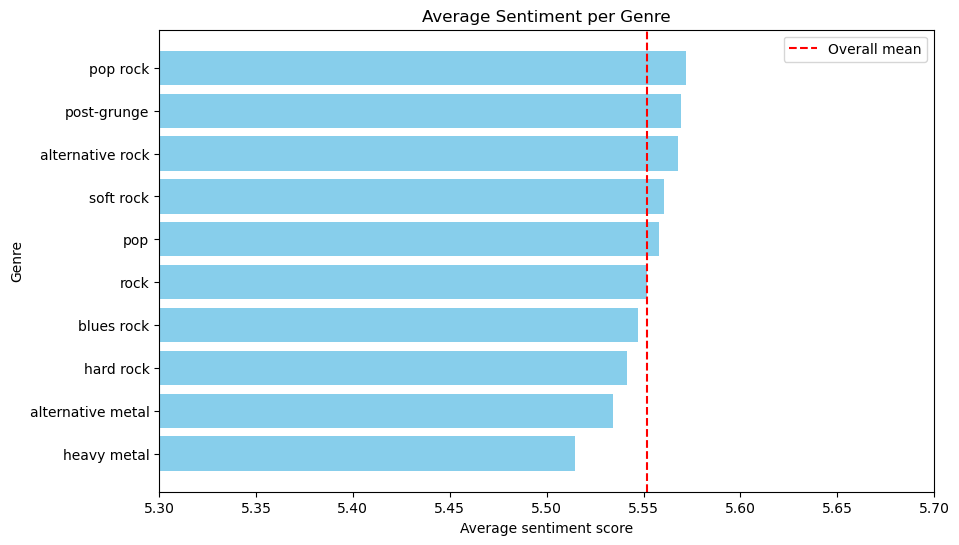

In [ ]:
# entiment per genre

# Extract genres for each node
genre_sentiments = defaultdict(list)

for node, data in G.nodes(data=True):
    sentiment = data.get("sentiment")
    genres = data.get("genres")

    if sentiment is None or genres is None:
        continue

    if isinstance(genres, str):
        try:
            genres = ast.literal_eval(genres)
        except Exception:
            genres = [genres]

    if not isinstance(genres, (list, tuple)):
        genres = [genres]

    # Assign sentiment to each genre 
    for genre in genres:
        genre_sentiments[genre].append(sentiment)

# Aggregate mean 
genre_stats = []
for genre, values in genre_sentiments.items():
    if len(values) > 40:  # ignore rare genres
        genre_stats.append({
            "genre": genre,
            "n_bands": len(values),
            "mean_sentiment": np.mean(values),
            "median_sentiment": np.median(values),
            "std_sentiment": np.std(values)
        })

df_genre_sent = pd.DataFrame(genre_stats).sort_values("mean_sentiment", ascending=False)
# print(df_genre_sent.head(20))

plt.figure(figsize=(10,6))
plt.barh(df_genre_sent["genre"], df_genre_sent["mean_sentiment"], color='skyblue')
plt.axvline(np.mean([d["mean_sentiment"] for d in genre_stats]), color='red', linestyle='--', label='Overall mean')
plt.xlabel("Average sentiment score")
plt.ylabel("Genre")
plt.title("Average Sentiment per Genre")
plt.legend()
plt.gca().invert_yaxis()
plt.xlim(5.3, 5.7)
plt.show()


Although that the overall variation is quite small, we still see a clear pattern. Pop rock, post-grunge, and alternative rock have the highest average sentiment scores, while heavy metal and alternative metal appear at the lower end. This of course alligns quite well with the general narative that metal genres are charaterized by darker language, while pop-oriented genres are more positiv.

---

#### Statistics and visualization

---



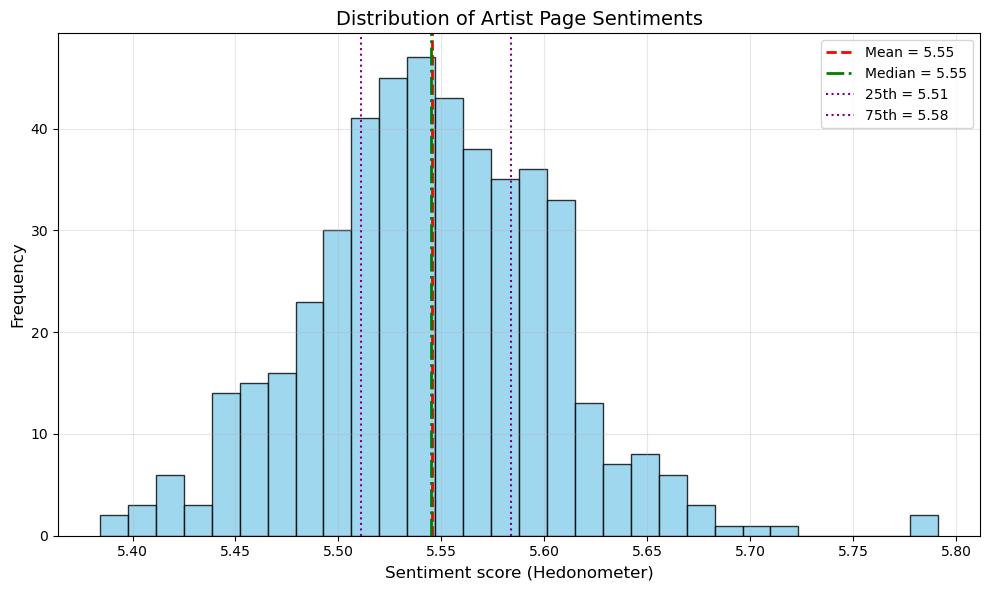

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Extract sentiment values from your graph
sentiments = nx.get_node_attributes(G, "sentiment")

# Convert to numpy array for easy stats
sentiment_values = np.array(list(sentiments.values()))

# Compute summary statistics
mean_val = np.mean(sentiment_values)
median_val = np.median(sentiment_values)
var_val = np.var(sentiment_values)
p25 = np.percentile(sentiment_values, 25)
p75 = np.percentile(sentiment_values, 75)

# Histogram
plt.figure(figsize=(10,6))
plt.hist(sentiment_values, bins=30, color="skyblue", edgecolor="black", alpha=0.8)
plt.title("Distribution of Artist Page Sentiments", fontsize=14)
plt.xlabel("Sentiment score (Hedonometer)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Add vertical lines for summary stats
plt.axvline(mean_val, color="red", linestyle="--", linewidth=2, label=f"Mean = {mean_val:.2f}")
plt.axvline(median_val, color="green", linestyle="-.", linewidth=2, label=f"Median = {median_val:.2f}")
plt.axvline(p25, color="purple", linestyle=":", linewidth=1.5, label=f"25th = {p25:.2f}")
plt.axvline(p75, color="purple", linestyle=":", linewidth=1.5, label=f"75th = {p75:.2f}")

plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Our histgram shows us that we have a very narrow spread of sentiment scores, wit hvalues clustered closely around the mean 5.55. Only a very small deviation in sentiment score seperates the "saddest" and "happiest" artist. This is to be expected since wikipidia strives to be as neutral in tone and objective as they can. The only cause for the fluctuations would be describtions of lyrics, events or biographical details regarding the bands.  

In [7]:
# Sort bands by sentiment
sorted_bands = sorted(sentiments.items(), key=lambda x: x[1])

# 10 saddest
print("\n 10 Saddest artists:")
for band, val in sorted_bands[:10]:
    print(f"{band:30s}  {val:.2f}")

# 10 happiest
print("\n 10 Happiest artists:")
for band, val in sorted_bands[-10:][::-1]:  
    print(f"{band:30s}  {val:.2f}")



 10 Saddest artists:
Gary_Glitter                    5.38
Canned_Heat                     5.40
Marilyn_Manson                  5.40
W_A_S_P___band_                 5.41
Five_Finger_Death_Punch         5.41
Ted_Nugent                      5.42
Black_Sabbath                   5.42
Rage_Against_the_Machine        5.42
Pantera                         5.42
Sex_Pistols                     5.42

 10 Happiest artists:
Tracy_Chapman                   5.79
Lenny_Kravitz                   5.79
The_Boxtones                    5.72
Edgar_Winter                    5.70
Michael_Martin_Murphey          5.69
The_Cardigans                   5.68
Greta_Van_Fleet                 5.67
Fun__band_                      5.67
Train__band_                    5.67
Manfred_Mann_Chapter_Three      5.67


Generally we see here that artist in the metal genres are "sadder" then those accosiated with pop, which alligns well with our per-genre sentiment analysis. We do have outliers though, such as Gary Glitter, that are considered a pop-musician, ranked as the "saddedst" artist. The reason for his supposed sadness quickly beacomes apparent when skimming his wikipedia page, as a big part of his wiki-page is focused on his sexual offenses and criminal record. 

---

### Discuss the sentiment of the communities. Do the findings using TF-IDF during Lecture 7 help you understand your results?

---

When looking at the list of saddest and happiest artist, we needn't read a lot of the their wikipages to make sense of the results. We can take the happiest artist 'Tracy Chapan' and compare to of the saddest 'Marilyn Manson'. Tracy Chapman is an award winning artist with a lot of critically aclaimed songs and albums, who is also considered to an social activist that does charity work. Compring here to 'Marilyn Manson' whos name alone is a combination [quoting from wikipidea] '... an American female sex symbol with the last name of a male serial killer', and has been considered by some to have influenced the perpetrators of the columbine high school massacre. With this it isnt a suprise that these artist have the sentiment score they do. 

Tracy chapman are considered to make pop and blues rock while Marilyn Manson are associated with 'alternative metal' and gothick rock. We found earlier that alternative metal has the lowest mean sentiment score while pop has the highest. This is complimented by the result from the TF-IDF analysis, that showed that pop and soft rock are characterized by words like "hit", "single" and "concert" somewhat reflecting positive themes of succes and recognition. While alternative metal and grunge is accosiated with words like "studio", “record”, and “tour” suggesting a more factual tone. So while the TF-IDF does not give us an idea of the emotion in the wiki pages, it supports the pattern we found in the sentiment analysis, that pop related communities has a slightly more postive textual framing than "heavier" genres.